In [2]:
import torch

depth = torch.load('/home/azhuravl/scratch/datasets_latents/driving_1000/002/videos/ref_depths.pt')
depth.shape

/tmp/ipykernel_3382711/4235522030.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  depth = torch.load('/home/azhuravl/scratch/datasets_latents/driving_1000/002/videos/ref

torch.Size([10, 1, 384, 672])

In [3]:
import sys
sys.path.append('/home/azhuravl/work/TrajectoryCrafter/notebooks/22_10_25_scaling_up')
from generate_sceneflow import apply_colormap_to_depth


/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [4]:
sys.path.append('/home/azhuravl/work/TrajectoryCrafter/notebooks/05_11_25_training/lora_utils_ours')

from dataset_videos import SimpleValidationDataset

dataset = SimpleValidationDataset(
    '/home/azhuravl/scratch/datasets_latents/driving_1000',
    max_samples=5, use_depth=True
    )

Found 5 validation samples (depth mode)


In [15]:
data_0 = dataset[0]
# data_0

In [8]:
data_0['warped_video'].shape

torch.Size([3, 49, 384, 672])

In [43]:
def convert_depth_sample_to_rgb(depth_tensor):
    # sample (1, C, T, H, W)
    # input [T, H, W]
    # output [T, H, W, 3]
    
    depth_thw = depth_tensor.mean(dim=1, keepdim=False)[0]  # [T, H, W]
    
    # unnormalize depth to min 1, max 100, 
    # set values where depth_thw is zero to zero
    depth_thw_unnorm = depth_thw * (100.0 - 1.0) + 1.0
    depth_thw_unnorm = torch.where(depth_thw > 0, depth_thw_unnorm, torch.zeros_like(depth_thw_unnorm))
    
    depth_colormap = apply_colormap_to_depth(depth_thw_unnorm, inverse=True)  # [T, H, W, 3]
    depth_bcthw = depth_colormap.permute(3, 0, 1, 2).unsqueeze(0)  # [1, 3, T, H, W]
    return depth_bcthw


In [47]:
depth_bcthw = convert_depth_sample_to_rgb(
    data_0['warped_video'].unsqueeze(0)
    )

In [48]:
depth_bcthw.shape

torch.Size([1, 3, 49, 384, 672])

In [49]:
from videox_fun.utils.utils import save_videos_grid

save_videos_grid(
    depth_bcthw, 
    '/home/azhuravl/work/TrajectoryCrafter/notebooks/05_11_25_training/test_depth_vis.mp4',
)

In [1]:
# load /home/azhuravl/work/TrajectoryCrafter/experiments/07-11-2025/13-33-14/checkpoint-1.safetensors
import torch
from safetensors.torch import load_file

state_dict = load_file(
    '/home/azhuravl/work/TrajectoryCrafter/experiments/07-11-2025/13-33-14/checkpoint-1.safetensors'
    )   
state_dict.keys()

dict_keys(['lora_unet__norm_out_linear.alpha', 'lora_unet__norm_out_linear.lora_down.weight', 'lora_unet__norm_out_linear.lora_up.weight', 'lora_unet__perceiver_cross_attention_0_to_kv.alpha', 'lora_unet__perceiver_cross_attention_0_to_kv.lora_down.weight', 'lora_unet__perceiver_cross_attention_0_to_kv.lora_up.weight', 'lora_unet__perceiver_cross_attention_0_to_q.alpha', 'lora_unet__perceiver_cross_attention_0_to_q.lora_down.weight', 'lora_unet__perceiver_cross_attention_0_to_q.lora_up.weight', 'lora_unet__proj_out.alpha', 'lora_unet__proj_out.lora_down.weight', 'lora_unet__proj_out.lora_up.weight', 'lora_unet__transformer_blocks_0_attn1_to_q.alpha', 'lora_unet__transformer_blocks_0_attn1_to_q.lora_down.weight', 'lora_unet__transformer_blocks_0_attn1_to_q.lora_up.weight', 'lora_unet__transformer_blocks_0_attn1_to_v.alpha', 'lora_unet__transformer_blocks_0_attn1_to_v.lora_down.weight', 'lora_unet__transformer_blocks_0_attn1_to_v.lora_up.weight', 'lora_unet__transformer_blocks_10_attn1_t

In [2]:
import sys
sys.path.append('/home/azhuravl/work/TrajectoryCrafter/notebooks/05_11_25_training/lora_utils_ours')

from dataset_latents_double import LatentsDataset

dataset = LatentsDataset(
    data_dir='/home/azhuravl/scratch/datasets_latents/monkaa_1000',
    use_depth_latents=True,
)

Found 780 directories with both video and depth latents


In [4]:
data_0 = dataset[0]

In [8]:
data_0['depth_latents']['cond_video_latents'].shape

torch.Size([13, 16, 48, 84])

In [10]:
torch.linspace(0, 49-1, 35)

tensor([ 0.0000,  1.4118,  2.8235,  4.2353,  5.6471,  7.0588,  8.4706,  9.8824,
        11.2941, 12.7059, 14.1176, 15.5294, 16.9412, 18.3529, 19.7647, 21.1765,
        22.5882, 24.0000, 25.4118, 26.8235, 28.2353, 29.6471, 31.0588, 32.4706,
        33.8824, 35.2941, 36.7059, 38.1176, 39.5294, 40.9412, 42.3529, 43.7647,
        45.1765, 46.5882, 48.0000])

In [1]:
# read and print the keys with shapes of /home/azhuravl/scratch/datasets_latents/monkaa_ref_latents/001/ref_videos_latents.pt
import torch

latents = torch.load('/home/azhuravl/scratch/datasets_latents/monkaa_ref_latents/001/ref_videos_latents.pt')
for k, v in latents.items():
    print(k, v.shape)

ref_latents_10_frames torch.Size([1, 3, 16, 48, 84])
ref_latents_20_frames torch.Size([1, 5, 16, 48, 84])
ref_latents_30_frames torch.Size([1, 8, 16, 48, 84])
ref_latents_35_frames torch.Size([1, 9, 16, 48, 84])
ref_latents_40_frames torch.Size([1, 10, 16, 48, 84])


/tmp/ipykernel_1395950/3041759288.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latents = torch.load('/home/azhuravl/scratch/datasets_latents/monkaa_ref_latents/001/re

In [1]:
print(2
    )

2


In [1]:
# load this /home/azhuravl/work/TrajectoryCrafter/experiments/08-11-2025/12-11-14/snapshot_0030.pickle

import pickle
with open('/home/azhuravl/work/TrajectoryCrafter/experiments/08-11-2025/12-11-14/snapshot_0030.pickle', 'rb') as f:
    snapshot = pickle.load(f)


In [6]:
import json
# save snapshot as json
with open('/home/azhuravl/work/TrajectoryCrafter/experiments/08-11-2025/12-11-14/snapshot_0030.json', 'w') as f:
    json.dump(snapshot, f)

KeyboardInterrupt: 

In [1]:
import torch

torch.linspace(0, 49-1, 49).long()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [1]:
import torch

data = torch.load('/home/azhuravl/work/TrajectoryCrafter/experiments/12-11-2025/debug/gt_depth_inv_resized.pt', weights_only=True)

In [3]:
data.shape

torch.Size([1, 32, 1, 266, 448])

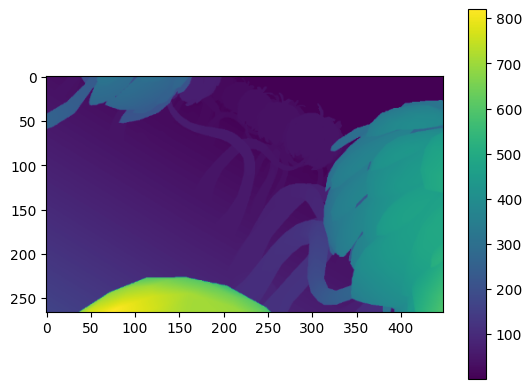

In [6]:
import matplotlib.pyplot as plt

plt.imshow(data[0, 0, 0])
plt.colorbar()

In [13]:
import imageio
import numpy as np
from matplotlib import cm

def save_video(frames, output_video_path, fps=10, is_depths=False, grayscale=False):
    writer = imageio.get_writer(output_video_path, fps=fps, macro_block_size=1, codec='libx264', ffmpeg_params=['-crf', '18'])
    if is_depths:
        colormap = np.array(cm.get_cmap("inferno").colors)
        d_min, d_max = frames.min(), frames.max()
        print(f"Depth min: {d_min}, max: {d_max}")
        for i in range(frames.shape[0]):
            depth = frames[i]
            depth_norm = ((depth - d_min) / (d_max - d_min) * 255).astype(np.uint8)
            depth_vis = (colormap[depth_norm] * 255).astype(np.uint8) if not grayscale else depth_norm
            writer.append_data(depth_vis)
    else:
        for i in range(frames.shape[0]):
            writer.append_data(frames[i])

    writer.close()

In [14]:
d_max

NameError: name 'd_max' is not defined

In [15]:
save_video(
    data[0,:, 0].numpy(),
    '/home/azhuravl/work/TrajectoryCrafter/experiments/12-11-2025/debug/test_save.mp4',
    is_depths=True,
)

Depth min: 1.0238792896270752, max: 58853316.0


/tmp/ipykernel_2542143/1622533964.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = np.array(cm.get_cmap("inferno").colors)
